# Exploring Movie Industry Insights for Microsoft Movie Studio

## Overview

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. We are charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

## Business Problem

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas in vulputate orci, eget posuere massa. Cras at lectus vel diam porta viverra. Ut vehicula congue aliquam. Suspendisse finibus risus quis hendrerit rhoncus. Sed euismod semper hendrerit. Sed nec vulputate diam.

## Data Understanding

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas in vulputate orci, eget posuere massa. Cras at lectus vel diam porta viverra. Ut vehicula congue aliquam. Suspendisse finibus risus quis hendrerit rhoncus. Sed euismod semper hendrerit. Sed nec vulputate diam.

In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [58]:
# We will be working primairly with three datasets.
# The first are easy to import since they are stored as files with comma-seperated values
box_office = pd.read_csv('data/bom.movie_gross.csv')
movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

In [3]:
# The other data source is a SQLite database from the Internet Movie Database (IMDB).
conn = sqlite3.connect('data/im.db')

In [4]:
box_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [5]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### The IMDB Data
The IMDB data is composed of 8 different tables. Below is its ERD.

![IMDB ERD](images/imdb_erd.jpeg)

This dataset is the most roboust and likely contains more information than we need. A quick look at the movie_basics table shows us that the dataset contains information on 146,144 unique records between the years of 2010 and 2115 (which is either an error or at the very least something to look into when we do data cleaning).

Looking at the other tables in the databse, it looks like we also have information on each movie's: staff (actors, producers, writers, etc.), names of chartacters played by actors, some basic information on the people involved (like birth year and year of death), as well as info on movie ratings.

In [6]:
q = """
SELECT MIN(start_year), MAX(start_year), COUNT(DISTINCT movie_id)
FROM movie_basics
;"""

pd.read_sql(q, conn)

,MIN(start_year),MAX(start_year),COUNT(DISTINCT movie_id)
0,2010,2115,146144


In [7]:
q = """
SELECT primary_title, genres, primary_name
FROM movie_basics
JOIN directors
USING(movie_id)
JOIN persons
USING(person_id)
WHERE start_year BETWEEN 2000 AND 2020
AND primary_name == 'Sam Raimi'
GROUP BY movie_id
;"""

pd.read_sql(q, conn)

,primary_title,genres,primary_name
0,Oz the Great and Powerful,"Adventure,Family,Fantasy",Sam Raimi


### Box Office Data

The box office comes from Box Office Mojo. It contains records on 3,386 unique movie titles between the years of 2010 and 2018. For each movie, it provides us with the movie's title, the studio which produced it, the domestic box office gross earnings, foreign box office gross earnings and the year of release.

In [8]:
box_office.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [9]:
# Get the range of years in the box office dataset

print('The data sets begins in the year:', box_office['year'].min())
print('The dataset contains data on movies through the year: ', box_office['year'].max())

box_office.groupby('studio').count()

The data sets begins in the year: 2010
The dataset contains data on movies through the year:  2018


,title,domestic_gross,foreign_gross,year
studio,,,,
3D,1,1,1,1
A23,2,2,0,2
A24,49,49,19,49
ADC,2,2,0,2
AF,6,6,2,6
...,...,...,...,...
XL,2,2,0,2
YFG,1,1,0,1
Yash,14,13,7,14


In [10]:
# How many unique movies titles are in the dataset?
box_office['title'].nunique()

3386

### Movie Budgets Data

The movie budgets data comes from The-Numbers.com. It contains records on 5,698 unique movie titles between the years of 1915 and 2020. For each movie, it provides us with the movie's release date, its title, its production budget, and its foreign and domestic box office earnings.

In [11]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [12]:
# How many unique movies titles are in the dataset?
movie_budgets['movie'].nunique()

5698

In [13]:
# Get the range of years in the box office dataset

movie_budgets['year'] = movie_budgets['release_date'].str[-4:]

print('The data sets begins in the year:', movie_budgets['year'].min())
print('The dataset contains data on movies through the year: ', movie_budgets['year'].max())

The data sets begins in the year: 1915
The dataset contains data on movies through the year:  2020


## Data Preperation

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas in vulputate orci, eget posuere massa. Cras at lectus vel diam porta viverra. Ut vehicula congue aliquam. Suspendisse finibus risus quis hendrerit rhoncus. Sed euismod semper hendrerit. Sed nec vulputate diam.

### Data Cleaning
Lorem ipsum dolor sit amet, consectetur adipiscing elit.

Looking at the box_office dataset first, it looks like there are some missing values. The movie studio is missing on X records, domestic_gross is missing on 28 records and foreign_gross is missing on 1,350 records.

In [14]:
box_office.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

The missing studio and domestic_gross records are small. If we had to drop them it wouldn't make much of a difference.
However, we are missing foreign_gross on a substantial chunk of the dataset so it's worth taking a closer look at those values.

In [15]:
box_office[box_office['foreign_gross'].isna()]

,title,studio,domestic_gross,foreign_gross,year
222,Flipped,WB,1800000.0,NaN,2010
254,The Polar Express (IMAX re-issue 2010),WB,673000.0,NaN,2010
267,Tiny Furniture,IFC,392000.0,NaN,2010
269,Grease (Sing-a-Long re-issue),Par.,366000.0,NaN,2010
280,Last Train Home,Zeit.,288000.0,NaN,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


Taking 'Flipped' as an example, it looks like this data is really missing. Looking at The Numbers website for this movie it DID get a international release. Furthermore, if we look at the same movie in our movie_budgets dataset, we can see complete data there. Moreover, the data on domestic and foreign gross here looks more precise and appears to be rounded in the box_office dataset. Because of that, we can just rely on data on worldwide gorss sales using the movie_budgets source. We will use box_office just to get the studio names for each movie.

In [16]:
movie_budgets[movie_budgets['movie'].str.contains("Flipped")]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
3221,22,"Aug 6, 2010",Flipped,"$14,000,000","$1,755,212","$4,289,993",2010


Next, the box_office title column also contains some entries that aren't the film's title. For example, Alice in Wonderland (2010) has '(2010)' in the title despite it not being part of the original title. We want to find those instances and clean them up.

In [17]:
replacement = ['\(2010\)','\(2011\)','\(2012\)','\(2013\)','\(2014\)','\(2015\)','\(2016\)','\(2017\)','\(2018\)',]
box_office['title'] = box_office['title'].replace(replacement,"", regex=True)
box_office[['title_cleaned','title_notes']] = box_office.title.str.split(pat='\(',expand=True)

# I will also run a strip just in case we were left with any unwanted whitespace after the last operation

box_office['title_cleaned'] = box_office['title_cleaned'].str.strip()

Let's take a closer look at movie_budgets next. Initially, it looks like the dataset has no misisng values. However, just because it doesn't have Null values doesn't mean some values don't have a placeholder. So we'll investigate this dataset more closely.

In [18]:
movie_budgets['worldwide_gross'].value_counts().sort_values(ascending=False)

$0              367
$8,000,000        9
$7,000,000        6
$2,000,000        6
$15,000,000       4
               ... 
$14,189,810       1
$18,309,793       1
$549,588,516      1
$236,827,677      1
$18,594,227       1
Name: worldwide_gross, Length: 5356, dtype: int64

worldwide_gross has 367 occourances of $0. That's the only unusual high count occourance. Let's take a look at those records.

Before we do that, it will be helpful to convert the values in these numeric columns from objects to floats.

In [19]:
movie_budgets[movie_budgets.columns[3:]] = movie_budgets[movie_budgets.columns[3:]].replace('[\$,]', '', regex=True).astype(float)

# Now let's look at those records where the worldwide_gross is equal to 0

movie_budgets_zero = movie_budgets.loc[movie_budgets['worldwide_gross'] == 0]

movie_budgets_zero

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,150000000.0,0.0,0.0,2020.0
479,80,"Dec 13, 2017",Bright,90000000.0,0.0,0.0,2017.0
480,81,"Dec 31, 2019",Army of the Dead,90000000.0,0.0,0.0,2019.0
535,36,"Feb 21, 2020",Call of the Wild,82000000.0,0.0,0.0,2020.0
670,71,"Aug 30, 2019",PLAYMOBIL,75000000.0,0.0,0.0,2019.0
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000.0,0.0,0.0,2014.0
5764,65,"Dec 31, 2007",Tin Can Man,12000.0,0.0,0.0,2007.0
5771,72,"May 19, 2015",Family Motocross,10000.0,0.0,0.0,2015.0
5777,78,"Dec 31, 2018",Red 11,7000.0,0.0,0.0,2018.0


Some of the above results are streaming releases, meaning they never had a box office. There, a value of 0 makes sense. This applies, for example, to Bright. However, for other movies the data is just missing. For example, a quick search shows that Army of the Dead (released Dec 31, 2019) made $1 million at the Box Offce.

Since this is just 367 rows out of 5,782 I'm deciding to simply drop these values. Lastly, I also rename the column "movie" to "title" so that it more closely matches the other dataframes we're working with.

In [20]:
# movie_budgets_clean = movie_budgets[movie_budgets['worldwide_gross'] > 0]
movie_budgets.drop(movie_budgets[movie_budgets.worldwide_gross == 0].index, inplace=True)
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5415 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5415 non-null   int64  
 1   release_date       5415 non-null   object 
 2   movie              5415 non-null   object 
 3   production_budget  5415 non-null   float64
 4   domestic_gross     5415 non-null   float64
 5   worldwide_gross    5415 non-null   float64
 6   year               5415 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 338.4+ KB


### Merging Data Sets
The three data sources we want to merge do not have a common key. Therefore we need to create one.

While movie titles may repeat, it's rarer for a movie title to repeat within the same year. So, we will create a dataframe using a Title/Year pairing.

Because movie_budgets has the most relevant information we're after about a movie's performence (its budget and revenue) we will join the other data sources onto it.

In [21]:
movie_budgets['year'] = movie_budgets['release_date'].str[-4:]
movie_budgets['title/year'] = movie_budgets['movie'] + '/' + movie_budgets['year']
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,title/year
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009,Avatar/2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides/2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix/2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron/2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi/2017


In [22]:
box_office['title/year'] = box_office['title_cleaned'] + '/' + box_office['year'].astype(str)
box_office.head()

,title,studio,domestic_gross,foreign_gross,year,title_cleaned,title_notes,title/year
0,Toy Story 3,BV,415000000.0,652000000,2010,Toy Story 3,None,Toy Story 3/2010
1,Alice in Wonderland,BV,334200000.0,691300000,2010,Alice in Wonderland,None,Alice in Wonderland/2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,Harry Potter and the Deathly Hallows Part 1,None,Harry Potter and the Deathly Hallows Part 1/2010
3,Inception,WB,292600000.0,535700000,2010,Inception,None,Inception/2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,Shrek Forever After,None,Shrek Forever After/2010


In [23]:
first_merge = pd.merge(movie_budgets,box_office, how="left", on='title/year')
first_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5416 entries, 0 to 5415
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5416 non-null   int64  
 1   release_date       5416 non-null   object 
 2   movie              5416 non-null   object 
 3   production_budget  5416 non-null   float64
 4   domestic_gross_x   5416 non-null   float64
 5   worldwide_gross    5416 non-null   float64
 6   year_x             5416 non-null   object 
 7   title/year         5416 non-null   object 
 8   title              1327 non-null   object 
 9   studio             1326 non-null   object 
 10  domestic_gross_y   1325 non-null   float64
 11  foreign_gross      1158 non-null   object 
 12  year_y             1327 non-null   float64
 13  title_cleaned      1327 non-null   object 
 14  title_notes        3 non-null      object 
dtypes: float64(5), int64(1), object(9)
memory usage: 677.0+ KB


Lastly, we want to merge in data from IMBD into this dataframe.

In [24]:
q = """
SELECT mb.primary_title AS title, mb.genres, mb.start_year AS year, p.primary_name AS director
FROM movie_basics AS mb
JOIN directors AS d
USING(movie_id)
JOIN persons AS p
USING(person_id)
;"""

imdb_data = pd.read_sql(q, conn)
imdb_data

,title,genres,year,director
0,Sunghursh,"Action,Crime,Drama",2013,Harnam Singh Rawail
1,Sunghursh,"Action,Crime,Drama",2013,Harnam Singh Rawail
2,Sunghursh,"Action,Crime,Drama",2013,Harnam Singh Rawail
3,Sunghursh,"Action,Crime,Drama",2013,Harnam Singh Rawail
4,One Day Before the Rainy Season,"Biography,Drama",2019,Mani Kaul
...,...,...,...,...
291166,6 Gunn,None,2017,Kiran Gawade
291167,Chico Albuquerque - Revelações,Documentary,2013,Vinicius Augusto Bozzo
291168,Chico Albuquerque - Revelações,Documentary,2013,Vinicius Augusto Bozzo
291169,Chico Albuquerque - Revelações,Documentary,2013,Angela Gurgel


In [25]:
imdb_data['title/year'] = imdb_data['title'] + '/' + imdb_data['year'].astype(str)

In [26]:
combined_data = pd.merge(first_merge,imdb_data, how="left", on='title/year')

In [27]:
# Not all the rows had matches so let's only look at rows where we sucessfully matched a director.
combined_data = combined_data[combined_data['director'].notna()]
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 1 to 8486
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4455 non-null   int64  
 1   release_date       4455 non-null   object 
 2   movie              4455 non-null   object 
 3   production_budget  4455 non-null   float64
 4   domestic_gross_x   4455 non-null   float64
 5   worldwide_gross    4455 non-null   float64
 6   year_x             4455 non-null   object 
 7   title/year         4455 non-null   object 
 8   title_x            3761 non-null   object 
 9   studio             3761 non-null   object 
 10  domestic_gross_y   3759 non-null   float64
 11  foreign_gross      3476 non-null   object 
 12  year_y             3761 non-null   float64
 13  title_cleaned      3761 non-null   object 
 14  title_notes        0 non-null      object 
 15  title_y            4455 non-null   object 
 16  genres             4452 

In [28]:
combined_data = combined_data.drop_duplicates()

In [29]:
# Next, we clean up the dataframe since after all these merges we ended up with some redundant columns

combined_data = combined_data.drop(['title_x','domestic_gross_x','title/year',
                                   'domestic_gross_y','title_notes','title_y',
                                   'foreign_gross','year_y','year','release_date','title_cleaned'], 1)

In [30]:
# Finally, I clean up the column titles a little bit to make them easier to work with

combined_data.rename(columns={"year_x": "year"})

,id,movie,production_budget,worldwide_gross,year,studio,genres,director
1,2,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,2011,BV,"Action,Adventure,Fantasy",Rob Marshall
6,3,Dark Phoenix,350000000.0,1.497624e+08,2019,NaN,"Action,Adventure,Sci-Fi",Simon Kinberg
12,4,Avengers: Age of Ultron,330600000.0,1.403014e+09,2015,BV,"Action,Adventure,Sci-Fi",Joss Whedon
19,7,Avengers: Infinity War,300000000.0,2.048134e+09,2018,BV,"Action,Adventure,Sci-Fi",Anthony Russo
31,7,Avengers: Infinity War,300000000.0,2.048134e+09,2018,BV,"Action,Adventure,Sci-Fi",Joe Russo
...,...,...,...,...,...,...,...,...
8465,18,Tiny Furniture,50000.0,4.241490e+05,2010,IFC,"Comedy,Drama,Romance",Lena Dunham
8467,20,Counting,50000.0,8.374000e+03,2015,NaN,Documentary,Jem Cohen
8471,32,Raymond Did It,40000.0,3.632000e+03,2011,NaN,Horror,Travis Legge
8480,45,Emily,27000.0,3.547000e+03,2017,Hiber,Drama,Ryan Graves


We still have a few duplicates in here because of movies that have multiple directors.
For example, Avengers: Infinity War is in our dataset twice because it was directed by Joe Russo and his brother Anthony Russo. Let's handle that next.

In [31]:
duplicates = combined_data[combined_data.duplicated('movie')]
combined_data = pd.merge(combined_data,duplicates[['movie','director']],on='movie', how='left')

In [32]:
combined_data.head()

,id,movie,production_budget,worldwide_gross,year_x,studio,genres,director_x,director_y
0,2,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,2011,BV,"Action,Adventure,Fantasy",Rob Marshall,NaN
1,3,Dark Phoenix,350000000.0,1.497624e+08,2019,NaN,"Action,Adventure,Sci-Fi",Simon Kinberg,NaN
2,4,Avengers: Age of Ultron,330600000.0,1.403014e+09,2015,BV,"Action,Adventure,Sci-Fi",Joss Whedon,NaN
3,7,Avengers: Infinity War,300000000.0,2.048134e+09,2018,BV,"Action,Adventure,Sci-Fi",Anthony Russo,Joe Russo
4,7,Avengers: Infinity War,300000000.0,2.048134e+09,2018,BV,"Action,Adventure,Sci-Fi",Joe Russo,Joe Russo


In [34]:
combined_data = combined_data[combined_data['director_x'] != combined_data['director_y']]

In [35]:
# We also want to figure out which of these movies are indipendent. While a small independent film
# might get a 2x or more return on its production budget, it probably doesn't reach the scale
# that Microsoft would care about. 
#This website shows that independent films are usually made with less than $2 million:
# https://filmlifestyle.com/what-is-an-indie-film/

In [36]:
combined_data['type'] = combined_data['production_budget'].apply(lambda x: 
                                                                 'Indie' if x <= 2000000 else 'Non-indie')

final_data = combined_data[combined_data['type'] == 'Non-indie']

In [118]:
final_data.rename(columns={"director_x": "first_director","director_y": "second_director" })

,id,movie,production_budget,worldwide_gross,year_x,studio,genres,first_director,second_director,type,profit,percent_return,movie_status
0,2,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,2011,BV,"Action,Adventure,Fantasy",Rob Marshall,NaN,Non-indie,6.350639e+08,2.546673,Blockbuster
1,3,Dark Phoenix,350000000.0,1.497624e+08,2019,NaN,"Action,Adventure,Sci-Fi",Simon Kinberg,NaN,Non-indie,-2.002376e+08,0.427892,Flop
2,4,Avengers: Age of Ultron,330600000.0,1.403014e+09,2015,BV,"Action,Adventure,Sci-Fi",Joss Whedon,NaN,Non-indie,1.072414e+09,4.243841,Blockbuster
3,7,Avengers: Infinity War,300000000.0,2.048134e+09,2018,BV,"Action,Adventure,Sci-Fi",Anthony Russo,Joe Russo,Non-indie,1.748134e+09,6.827114,Blockbuster
5,9,Justice League,300000000.0,6.559452e+08,2017,WB,"Action,Adventure,Fantasy",Zack Snyder,NaN,Non-indie,3.559452e+08,2.186484,Blockbuster
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,31,The Lost Medallion: The Adventures of Billy Stone,2500000.0,5.496320e+05,2013,NaN,"Adventure,Family,Fantasy",Bill Muir,NaN,Non-indie,-1.950368e+06,0.219853,Flop
1687,38,8: The Mormon Proposition,2500000.0,1.002800e+05,2010,NaN,Documentary,Steven Greenstreet,Reed Cowan,Non-indie,-2.399720e+06,0.040112,Flop
1689,41,Underdogs,2500000.0,1.392649e+06,2013,NaN,"Adventure,Animation,Family",Juan José Campanella,Doug Dearth,Non-indie,-1.107351e+06,0.557060,Flop
1691,60,Do You Believe?,2300000.0,1.430493e+07,2015,PFR,Drama,Jon Gunn,NaN,Non-indie,1.200493e+07,6.219535,Blockbuster


#### Making Generes More Workable

In our analysis, we will want to extract some things based on the movies generes. However, currently all genra information is listed under a single column. Furthermore, there are over 200 unique combinations of generes.

We want to extract what are all the possible genra types and add them into our dataframe in a way that will make it easier to work with in our anlaysis.

In [114]:
genres_list = final_data['genres'].unique()
genres_list = genres_list.tolist()

unique_genere_list = []

for i in range(len(genres_list)):
    if genres_list[i] is not None:
            unique_genere_list.extend(genres_list[i].split(','))
    else:
        pass

unique_genere_list = list(set(unique_genere_list))

In [116]:
print(len(unique_genere_list))
print(unique_genere_list)

21
['Documentary', 'Crime', 'Romance', 'Family', 'Comedy', 'Western', 'Biography', 'Music', 'Sport', 'Drama', 'Adventure', 'Thriller', 'Animation', 'Fantasy', 'Sci-Fi', 'Action', 'War', 'Mystery', 'History', 'Horror', 'Musical']


Great! So it looks like we have 21 different genres. We can look into subsets of some of the broader categories.

In [143]:
final_data = final_data[final_data['genres'].notna()]

In [147]:
final_data['isAction'] = final_data['genres'].apply(lambda x: True if 'Action' in x else False)
final_data['isAdventure'] = final_data['genres'].apply(lambda x: True if 'Adventure' in x else False)
final_data['isDrama'] = final_data['genres'].apply(lambda x: True if 'Drama' in x else False)
final_data['isComedy'] = final_data['genres'].apply(lambda x: True if 'Comedy' in x else False)
final_data['isThriller'] = final_data['genres'].apply(lambda x: True if 'Thriller' in x else False)
final_data['isHorror'] = final_data['genres'].apply(lambda x: True if 'Horror' in x else False)
final_data['isRomance'] = final_data['genres'].apply(lambda x: True if 'Romance' in x else False)
final_data['isMusical'] = final_data['genres'].apply(lambda x: True if 'Musical' in x else False)
final_data['isDocumentary'] = final_data['genres'].apply(lambda x: True if 'Documentary' in x else False)

<ipython-input-147-62565ab70685>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['isAction'] = final_data['genres'].apply(lambda x: True if 'Action' in x else False)
<ipython-input-147-62565ab70685>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['isAdventure'] = final_data['genres'].apply(lambda x: True if 'Adventure' in x else False)
<ipython-input-147-62565ab70685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [148]:
final_data.tail()

,id,movie,production_budget,worldwide_gross,year_x,studio,genres,director_x,director_y,type,...,movie_status,isAction,isAdventure,isDrama,isComedy,isThriller,isHorror,isRomance,isMusical,isDocumentary
1686,31,The Lost Medallion: The Adventures of Billy Stone,2500000.0,549632.0,2013,NaN,"Adventure,Family,Fantasy",Bill Muir,NaN,Non-indie,...,Flop,False,True,False,False,False,False,False,False,False
1687,38,8: The Mormon Proposition,2500000.0,100280.0,2010,NaN,Documentary,Steven Greenstreet,Reed Cowan,Non-indie,...,Flop,False,False,False,False,False,False,False,False,True
1689,41,Underdogs,2500000.0,1392649.0,2013,NaN,"Adventure,Animation,Family",Juan José Campanella,Doug Dearth,Non-indie,...,Flop,False,True,False,False,False,False,False,False,False
1691,60,Do You Believe?,2300000.0,14304931.0,2015,PFR,Drama,Jon Gunn,NaN,Non-indie,...,Blockbuster,False,False,True,False,False,False,False,False,False
1692,63,Frontera,2300000.0,59696.0,2014,NaN,"Drama,Thriller,Western",Michael Berry,NaN,Non-indie,...,Flop,False,False,True,False,True,False,False,False,False


### Creating Features

Now that we have all the data we wanted combined in one place, it's time to create some additional features in this dataset for use in our analysis.

In [149]:
final_data['profit'] = final_data['worldwide_gross'] - final_data['production_budget']
final_data['percent_return'] = final_data['worldwide_gross'] / final_data['production_budget']

<ipython-input-149-d0449d91c9c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['profit'] = final_data['worldwide_gross'] - final_data['production_budget']
<ipython-input-149-d0449d91c9c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['percent_return'] = final_data['worldwide_gross'] / final_data['production_budget']


In [39]:
# Let's create a function that checks whether the movie could be considered a success.
# I use this answer from quora to determine parameters for what is considered a Flop, Average, Hit, Super Hit
# or Blockbuster. https://www.quora.com/What-are-the-criteria-for-a-movie-hit-super-hit-blockbuster-and-flop

def movie_status_check(arg):
    status = None
    if arg < 1:
        status = 'Flop'
    elif 1 <= arg < 1.25:
        status = 'Average'
    elif 1.25 <= arg < 1.75:
        status = 'Hit'
    elif 1.75 <= arg < 2:
        status = 'Super Hit'
    else:
        status = 'Blockbuster'
    return status

In [150]:
final_data['movie_status'] = final_data['percent_return'].apply(movie_status_check)

<ipython-input-150-2f94ed6725c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['movie_status'] = final_data['percent_return'].apply(movie_status_check)


In [119]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1509 entries, 0 to 1692
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1509 non-null   int64  
 1   movie              1509 non-null   object 
 2   production_budget  1509 non-null   float64
 3   worldwide_gross    1509 non-null   float64
 4   year_x             1509 non-null   object 
 5   studio             1328 non-null   object 
 6   genres             1506 non-null   object 
 7   director_x         1509 non-null   object 
 8   director_y         398 non-null    object 
 9   type               1509 non-null   object 
 10  profit             1509 non-null   float64
 11  percent_return     1509 non-null   float64
 12  movie_status       1509 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 165.0+ KB


## Analysis

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas in vulputate orci, eget posuere massa. Cras at lectus vel diam porta viverra. Ut vehicula congue aliquam. Suspendisse finibus risus quis hendrerit rhoncus. Sed euismod semper hendrerit. Sed nec vulputate diam.

<AxesSubplot:xlabel='production_budget', ylabel='worldwide_gross'>

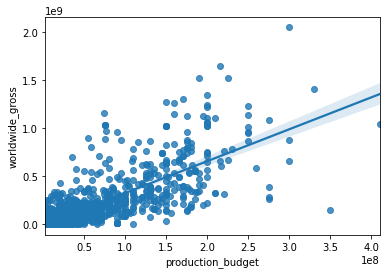

In [124]:
import seaborn as sns

sns.regplot(x=final_data["production_budget"], y=final_data["worldwide_gross"])

In [125]:
final_data["production_budget"].corr(final_data["worldwide_gross"])

0.7762994830533294

<AxesSubplot:xlabel='production_budget', ylabel='profit'>

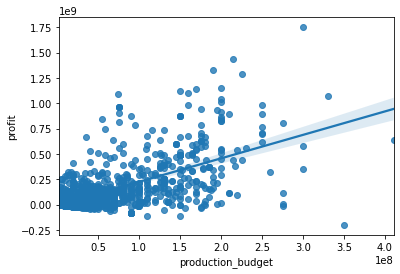

In [129]:
sns.regplot(x=final_data["production_budget"], y=final_data["profit"])

In [160]:
final_data.groupby('isAction')['production_budget'].describe()

,count,mean,std,min,25%,50%,75%,max
isAction,,,,,,,,
False,1080.0,3.522935e+07,4.374569e+07,2300000.0,10000000.0,18000000.0,40000000.0,260000000.0
True,426.0,8.474061e+07,7.009539e+07,3000000.0,30000000.0,62000000.0,129750000.0,410600000.0


## Conclusions

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas in vulputate orci, eget posuere massa. Cras at lectus vel diam porta viverra. Ut vehicula congue aliquam. Suspendisse finibus risus quis hendrerit rhoncus. Sed euismod semper hendrerit. Sed nec vulputate diam.

### Next Steps

Lorem ipsum dolor sit amet, consectetur adipiscing elit.

* Maecenas in vulputate orci, eget posuere massa.
* Cras at lectus vel diam porta viverra.
* Ut vehicula congue aliquam. 